In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/mnt/xfs/home/bencw/workspace/pretraining-distribution-shift-robustness


In [2]:
import numpy as np
import torch as ch
import torchvision
import matplotlib.pyplot as plt
from pathlib import Path

from src.experiments.splitting_shifts.imagenet import SplittingImagenetShiftsExperimentManager
import src.paths as paths
import src.dataset_utils as dataset_utils
import src.plotting_utils as plotting_utils

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
manager = SplittingImagenetShiftsExperimentManager(paths.STORE_PATH / "splitting_shifts", estimate_support=True)

## Plot ImageNet vs. shifted accuracy and compute effective robustness

In [4]:
def plot_with_effective_robustness(source_split="source_val", source_sub_split=None, target_split="sketch_val", target_sub_split=None):
    ax = plt.gca()
    plotting_utils.plot_on_the_line(
        manager,
        source_split=source_split,
        source_sub_split=source_sub_split,
        target_split=target_split,
        target_sub_split=target_sub_split,
        ax=ax,
    )
    plt.show()
    
    ers = manager.get_effective_robustness(
        source_split,
        target_split,
        "Baseline",
        model_names=[name for name in manager.model_names if "pretrained" in name],
        ref_sub_split_name=source_sub_split,
        shift_sub_split_name=target_sub_split,
    )
    mean_er = np.mean(list(ers.values()))
    print(f"Average effective robustness of pre-trained models: {mean_er}")
    return ers

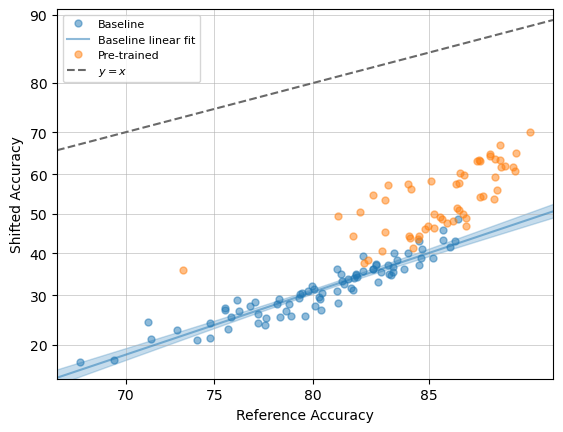

Average effective robustness of pre-trained models: 0.12247191980556058


In [5]:
_ = plot_with_effective_robustness(source_sub_split=None, target_split="sketch_val", target_sub_split=None)

## Visualize examples from in-support and out-of-support splits

In [6]:
from src.datasets.imagenet_utils import IMAGENET_COMMON_CLASS_NAMES
from torchvision.transforms.functional import resize, center_crop
from textwrap import wrap

In [7]:
def get_processed_image(dataset, index):
    image = dataset[index][0]
    size = 128
    image = center_crop(resize(image, size), (size, size))
    return image

def get_formatted_label_name(index, wrap_at=16):
    label_name = IMAGENET_COMMON_CLASS_NAMES[index]
    if wrap_at is not None:
        label_name = "\n".join(wrap(label_name, wrap_at))
    return label_name

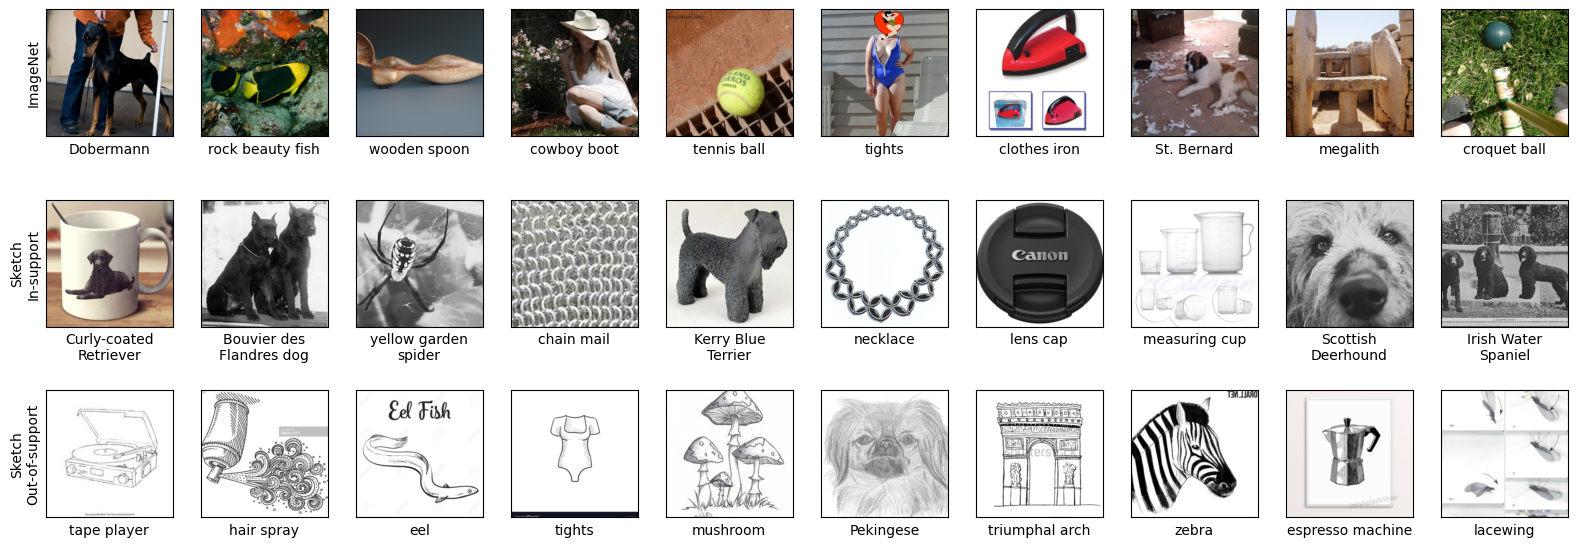

In [8]:
name = "sketch_val"
random_state = 0

random = np.random.RandomState(random_state)
source_dataset = torchvision.datasets.ImageFolder(Path(paths.IMAGENET_PATH) / "val")
dataset = manager.datasets[name[:-4]]
labels = manager.get_labels(name).cpu().numpy()
indices = manager.sub_indices[name]['shared_support_epsilon=0.1']
len(dataset), len(indices)

num_samples = 10

r = 2.0
fig, axs = plt.subplots(3, num_samples, figsize=(num_samples * r, 3.3 * r))
    
axs[0, 0].set_ylabel("ImageNet")
axs[1, 0].set_ylabel("Sketch\nIn-support")
axs[2, 0].set_ylabel("Sketch\nOut-of-support")

ref_indices = random.choice(len(source_dataset), size=num_samples, replace=False)
in_support_indices = random.choice(indices, size=num_samples, replace=False)
out_of_support_indices = random.choice(np.setdiff1d(np.arange(len(dataset)), indices), size=num_samples, replace=False)

for i in range(num_samples):
    ref_index = ref_indices[i]
    in_support_index = in_support_indices[i]
    out_of_support_index = out_of_support_indices[i]
    
    axs[0, i].imshow(get_processed_image(source_dataset, ref_index))
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[0, i].spines['left'].set_visible(True)
    axs[0, i].spines['bottom'].set_visible(True)
    axs[0, i].set_xlabel(get_formatted_label_name(manager.get_labels("source_val")[ref_index]))
    
    axs[1, i].imshow(get_processed_image(dataset, in_support_index))
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].spines['left'].set_visible(True)
    axs[1, i].spines['bottom'].set_visible(True)
    axs[1, i].set_xlabel(get_formatted_label_name(labels[in_support_index]))
    
    axs[2, i].imshow(get_processed_image(dataset, out_of_support_index))
    axs[2, i].set_xticks([])
    axs[2, i].set_yticks([])
    axs[2, i].spines['left'].set_visible(True)
    axs[2, i].spines['bottom'].set_visible(True)
    axs[2, i].set_xlabel(get_formatted_label_name(labels[out_of_support_index]))

plt.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

## Compute effective robustness for in-support and out-of-support splits

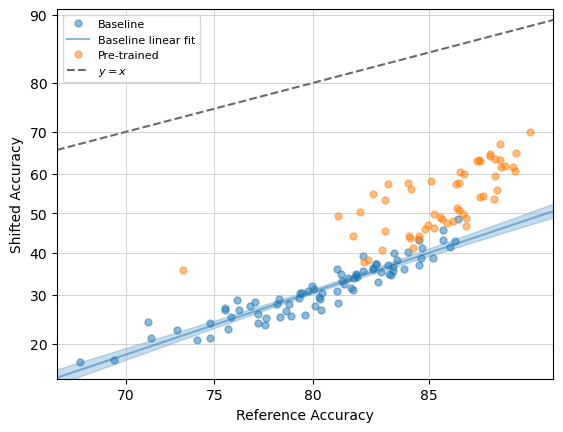

Average effective robustness of pre-trained models: 0.12286913489773954


In [9]:
# Out-of-support
_ = plot_with_effective_robustness(source_sub_split=None, target_split="sketch_val", target_sub_split='target_support_epsilon=0.1')

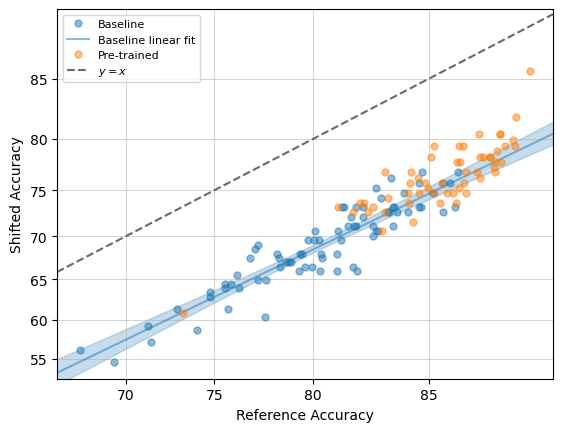

Average effective robustness of pre-trained models: 0.010534177686677802


In [10]:
# In-support
_ = plot_with_effective_robustness(source_sub_split=None, target_split="sketch_val", target_sub_split='shared_support_epsilon=0.1')